In [ ]:
!pip install -U torch==1.13.1+cu116 torchtext==0.6.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import torchtext
from torchtext.data import Field, Example
from torchtext.data import BucketIterator
from torchtext.vocab import GloVe
import matplotlib.pyplot as plt

## Data Cleaning

Using the "SMS Spam Collection Data Set" available at http://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection
  

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_dir = '/content/drive/MyDrive/2024-2025/Summer/APS360/Labs/Lab5/SMSSpamCollection'

In [ ]:
for line in open(data_dir):
    split_line = line.split("	")
    if split_line[0] == "ham":
      print(line)
      break

for line2 in open(data_dir):
    split_line2 = line2.split("	")
    if split_line2[0] == "spam":
      print(line2)
      break

ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's



Label value for spam: "spam"

Label value for non-spam: "ham"

In [ ]:
non_spam_counter = 0
for line in open(data_dir):
    split_line = line.split("	")
    if split_line[0] == "ham":
      non_spam_counter += 1

print("Number of non-span messages:", non_spam_counter)

spam_counter = 0
for line2 in open(data_dir):
    split_line2 = line2.split("	")
    if split_line2[0] == "spam":
      spam_counter += 1

print("Number of spam messages:", spam_counter)

Number of non-span messages: 4827
Number of spam messages: 747


In [ ]:
text_field = Field(sequential=True, use_vocab=True, tokenize=lambda x: x, batch_first=True, include_lengths=True)
label_field = Field(sequential=False, use_vocab=False)
fields = fields = [('sms', text_field), ('label', label_field), ]
examples = []

for line in open(data_dir):
    label, sms = line.split("\t")
    examples.append(Example.fromlist([sms, 1 if label == "spam" else 0], fields))

dataset = torchtext.data.Dataset(examples=examples, fields=fields)

In [ ]:
np.random.seed(42)
train, valid, test = dataset.split(split_ratio=[0.6, 0.2, 0.2], stratified=True, strata_field='label', random_state=None)

In [ ]:
# save the original training examples
old_train_examples = train.examples
# get all the spam messages in `train`
train_spam = []
for item in train.examples:
    if item.label == 1:
        train_spam.append(item)
# duplicate each spam message 6 more times
train.examples = old_train_examples + train_spam * 6

In [ ]:
text_field.build_vocab(train)
# text_field.vocab.stoi
# text_field.vocab.itos

text_field.vocab.stoi: A vocab object that will be used to numericalize a field. More specifically, stoi stands for "string to index."


text_field.vocab.itos: A vocab object that will be used to convert numerical indices back to token string. More specifically, itos stands for "index to string."

\<unk>: represents unknown tokens that were not found during training

\<pad>: represents padding and is used to pad sequences to equal lengths

In [ ]:
train_iter = torchtext.data.BucketIterator(train,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

In [ ]:
cntr = 0
for batch in train_iter:
    pad_num = 0
    if cntr == 10:
      break
    print("Batch #", cntr+1, ":")
    max_len = batch.sms[1][0]
    print("Maximum length is", max_len.item(), end="")

    for sms in batch.sms:
        pad_num += (sms == text_field.vocab.stoi["<pad>"]).sum().item()

    print(" and number of <pad> tokens is", pad_num, "\n")

    cntr += 1



Batch # 1 :
Maximum length is 29 and number of <pad> tokens is 26 

Batch # 2 :
Maximum length is 163 and number of <pad> tokens is 21 

Batch # 3 :
Maximum length is 156 and number of <pad> tokens is 0 

Batch # 4 :
Maximum length is 23 and number of <pad> tokens is 22 

Batch # 5 :
Maximum length is 77 and number of <pad> tokens is 48 

Batch # 6 :
Maximum length is 98 and number of <pad> tokens is 51 

Batch # 7 :
Maximum length is 74 and number of <pad> tokens is 31 

Batch # 8 :
Maximum length is 13 and number of <pad> tokens is 160 

Batch # 9 :
Maximum length is 87 and number of <pad> tokens is 74 

Batch # 10 :
Maximum length is 159 and number of <pad> tokens is 16 



## Model Building


In [ ]:
ident = torch.eye(10)
print(ident[0]) # one-hot vector
print(ident[1]) # one-hot vector
x = torch.tensor([[1, 2], [3, 4]])
print(ident[x]) # one-hot vectors

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]]])


In [ ]:
class SpamRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_class):
        super(SpamRNN, self).__init__()
        self.emb = torch.eye(input_size)
        self.hidden_size = hidden_size
        self.rnn = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_class)

    def forward(self, x):
        encodings = []
        for elem in x:
            encodings.append(self.emb[elem])

        x = torch.stack(encodings)

        # set the initial hidden states
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        # forward propagate the RNN
        out, _ = self.rnn(x)
        # pass the output of the last step to the classifier
        out = self.fc(out[:, -1, :])
        return out

## Training


In [ ]:
def get_accuracy(model, data):
    """ Compute the accuracy of the `model` across a dataset `data`

    Example usage:

    >>> model = MyRNN() # to be defined
    >>> get_accuracy(model, valid) # the variable `valid` is from above
    """
    correct = 0
    total = 0
    for batch in data:
        sms = batch.sms[0]
        labels = batch.label
        output = model(sms)
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += labels.shape[0]
    return correct / total

In [ ]:
def evaluate_val_loss(model, loader, criterion):
    total_val_loss = 0
    i = 0

    for batch in loader:
        sms = batch.sms[0]
        labels = batch.label
        pred = model(sms)
        loss = criterion(pred, labels)
        total_val_loss += loss.item()
        i += 1
    return float(total_val_loss)/(i+1)

In [ ]:
def train_model(model, train_loader, val_loader, num_epochs=10, learning_rate=0.001, plot=False):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    train_loss = np.zeros(num_epochs)
    train_acc = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    val_acc = np.zeros(num_epochs)
    total_epoch = 0

    for epoch in range(num_epochs):
      epoch_train_loss = 0
      i = 0
      for batch in train_loader:
          sms = batch.sms[0]
          labels = batch.label
          optimizer.zero_grad()
          pred = model(sms)
          loss = criterion(pred, labels)
          loss.backward()
          optimizer.step()

          epoch_train_loss += loss.item()
          i += 1

      # train loss and accuracy
      train_loss[epoch] = float(epoch_train_loss)/(i+1)
      train_acc[epoch] = get_accuracy(model, train_loader)

      # val loss and accuracy
      val_loss[epoch] = evaluate_val_loss(model, val_loader,criterion)
      val_acc[epoch] = get_accuracy(model, val_loader)

      print(("Epoch {}: Train accuracy: {}, Train loss: {} |"+ "Validation accuracy: {}, Validation loss: {}").format(epoch + 1, train_acc[epoch], train_loss[epoch], val_acc[epoch], val_loss[epoch]))

      # Save the current model (checkpoint) to a file
      # model_path = get_model_name(model.name,learning_rate, epoch) # torch.save(model.state_dict(), model_path)
    print("Finished training")


    if plot:
      # Plotting
      plt.title("Train vs Validation Loss")
      plt.plot(range(1 ,num_epochs+1), train_loss, label="Train")
      plt.plot(range(1 ,num_epochs+1), val_loss, label="Validation")
      plt.xlabel("Epochs")
      plt.ylabel("Loss")
      plt.legend(loc='best')
      plt.show()

      plt.title("Train vs Validation Accuracy")
      plt.plot(range(1 ,num_epochs+1), train_acc, label="Train")
      plt.plot(range(1 ,num_epochs+1), val_acc, label="Validation")
      plt.xlabel("Epochs")
      plt.ylabel("Training Accuracy")
      plt.legend(loc='best')
      plt.show()

In [ ]:
batch_size = 32

# train_iter = torchtext.data.BucketIterator(train,
#                                            batch_size=32,
#                                            sort_key=lambda x: len(x.sms), # to minimize padding
#                                            sort_within_batch=True,        # sort within each batch
#                                            repeat=False)                  # repeat the iterator for many epochs

val_iter = torchtext.data.BucketIterator(valid,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs


Epoch 1: Train accuracy: 0.9255636604774535, Train loss: 0.4688026258770965 |Validation accuracy: 0.9551971326164874, Validation loss: 0.23603445664048195
Epoch 2: Train accuracy: 0.9282161803713528, Train loss: 0.21370953138623583 |Validation accuracy: 0.9614695340501792, Validation loss: 0.15677466512554222
Epoch 3: Train accuracy: 0.9210875331564987, Train loss: 0.1878756267214684 |Validation accuracy: 0.9086021505376344, Validation loss: 0.3459832049492333
Epoch 4: Train accuracy: 0.95407824933687, Train loss: 0.16856309538216968 |Validation accuracy: 0.9489247311827957, Validation loss: 0.18230371611813703
Epoch 5: Train accuracy: 0.9232427055702918, Train loss: 0.14831795219430013 |Validation accuracy: 0.9650537634408602, Validation loss: 0.12872522370889783
Epoch 6: Train accuracy: 0.9525862068965517, Train loss: 0.15597762779308189 |Validation accuracy: 0.9480286738351255, Validation loss: 0.233381572800378
Epoch 7: Train accuracy: 0.9688328912466844, Train loss: 0.126158091271

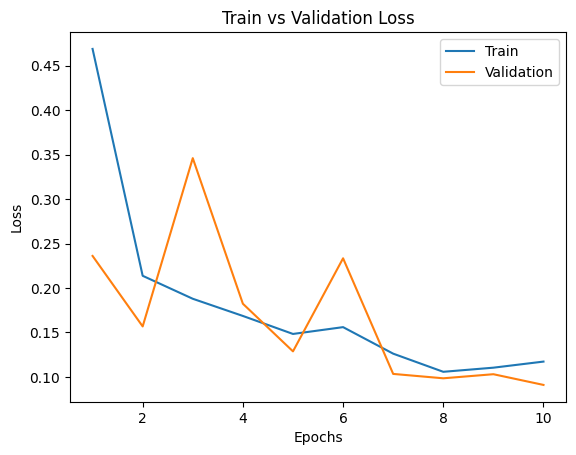

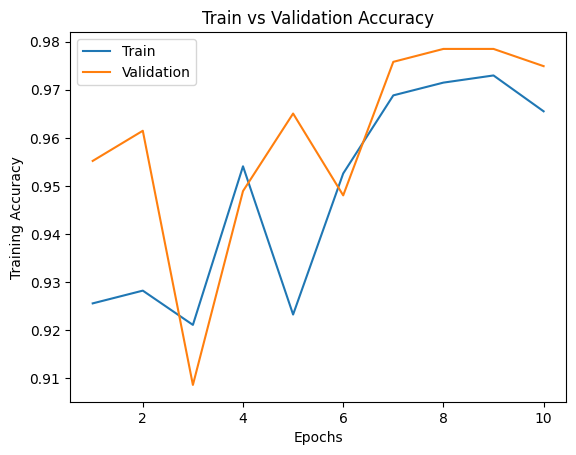

In [ ]:
model = SpamRNN(input_size=len(text_field.vocab.itos), hidden_size=50, num_class=2)
train_model(model, train_iter, val_iter, plot=True)


## Hyper Parameter Tuning

In [ ]:
# Test 1: increase learning rate to 0.01
train_model(model, train_iter, val_iter, plot=False, learning_rate = 0.01)

Epoch 1: Train accuracy: 0.9514257294429708, Train loss: 0.22656532569151175 |Validation accuracy: 0.9551971326164874, Validation loss: 0.1590762678016391
Epoch 2: Train accuracy: 0.9534151193633952, Train loss: 0.17608097639841666 |Validation accuracy: 0.9605734767025089, Validation loss: 0.1545614218339324
Epoch 3: Train accuracy: 0.9678381962864722, Train loss: 0.13137104689192616 |Validation accuracy: 0.9704301075268817, Validation loss: 0.12819824264281326
Epoch 4: Train accuracy: 0.9655172413793104, Train loss: 0.11298886792685249 |Validation accuracy: 0.9802867383512545, Validation loss: 0.09849717339966446
Epoch 5: Train accuracy: 0.9792771883289124, Train loss: 0.09707713330035882 |Validation accuracy: 0.9668458781362007, Validation loss: 0.11148419189784262
Epoch 6: Train accuracy: 0.9827586206896551, Train loss: 0.09149800220360416 |Validation accuracy: 0.9668458781362007, Validation loss: 0.13134750485834149
Epoch 7: Train accuracy: 0.9864058355437666, Train loss: 0.0469943

In [ ]:
# Test 2: decrease num epochs to 7
model = SpamRNN(input_size=len(text_field.vocab.itos), hidden_size=50, num_class=2)
train_model(model, train_iter, val_iter, plot=False, learning_rate = 0.001, num_epochs=7)

Epoch 1: Train accuracy: 0.9069960212201591, Train loss: 0.5256836504283312 |Validation accuracy: 0.956989247311828, Validation loss: 0.211033894163039
Epoch 2: Train accuracy: 0.9464522546419099, Train loss: 0.20685883582030473 |Validation accuracy: 0.9587813620071685, Validation loss: 0.19255960411909553
Epoch 3: Train accuracy: 0.9510941644562334, Train loss: 0.1733183876341699 |Validation accuracy: 0.9686379928315412, Validation loss: 0.14456764712101883
Epoch 4: Train accuracy: 0.9509283819628647, Train loss: 0.17704468231010986 |Validation accuracy: 0.9731182795698925, Validation loss: 0.12273918402691682
Epoch 5: Train accuracy: 0.9449602122015915, Train loss: 0.15807166566680136 |Validation accuracy: 0.974910394265233, Validation loss: 0.11008221790608433
Epoch 6: Train accuracy: 0.8023872679045093, Train loss: 0.41003352656568354 |Validation accuracy: 0.9229390681003584, Validation loss: 0.3579285028907988
Epoch 7: Train accuracy: 0.8624005305039788, Train loss: 0.376474514642

In [ ]:
# Test 3: change GRU to RNN
class SpamRNN2(nn.Module):
    def __init__(self, input_size, hidden_size, num_class):
        super(SpamRNN2, self).__init__()
        self.emb = torch.eye(input_size)
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_class)

    def forward(self, x):
        encodings = []
        for elem in x:
            encodings.append(self.emb[elem])

        x = torch.stack(encodings)

        # set the initial hidden states
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        # forward propagate the RNN
        out, _ = self.rnn(x)
        # pass the output of the last step to the classifier
        out = self.fc(out[:, -1, :])
        return out

RNN_model = SpamRNN2(input_size=len(text_field.vocab.itos), hidden_size=50, num_class=2)
train_model(RNN_model, train_iter, val_iter, plot=False)

Epoch 1: Train accuracy: 0.7853116710875332, Train loss: 0.5686487767257189 |Validation accuracy: 0.9166666666666666, Validation loss: 0.2985070273280144
Epoch 2: Train accuracy: 0.5750994694960212, Train loss: 0.4027388936006709 |Validation accuracy: 0.8539426523297491, Validation loss: 0.4564818971686893
Epoch 3: Train accuracy: 0.48010610079575594, Train loss: 0.45567039225838685 |Validation accuracy: 0.8655913978494624, Validation loss: 0.46765632265143925
Epoch 4: Train accuracy: 0.6763925729442971, Train loss: 0.6473862026867113 |Validation accuracy: 0.48028673835125446, Validation loss: 0.7055569258001115
Epoch 5: Train accuracy: 0.740550397877984, Train loss: 0.5674178069359378 |Validation accuracy: 0.7974910394265233, Validation loss: 0.50091260092126
Epoch 6: Train accuracy: 0.71684350132626, Train loss: 0.5115235084765836 |Validation accuracy: 0.5636200716845878, Validation loss: 0.6843887186712689
Epoch 7: Train accuracy: 0.8411803713527851, Train loss: 0.4557890380683698 |

In [ ]:
# Test 4: change hidden size to 30
model = SpamRNN(input_size=len(text_field.vocab.itos), hidden_size=30, num_class=2)
train_model(model, train_iter, val_iter, plot=False)

Epoch 1: Train accuracy: 0.9190981432360743, Train loss: 0.5704879506442108 |Validation accuracy: 0.9498207885304659, Validation loss: 0.26375748920771813
Epoch 2: Train accuracy: 0.9214190981432361, Train loss: 0.24460110610449 |Validation accuracy: 0.9731182795698925, Validation loss: 0.1603152004794942
Epoch 3: Train accuracy: 0.9123010610079576, Train loss: 0.22139208013878056 |Validation accuracy: 0.9713261648745519, Validation loss: 0.15501703404717976
Epoch 4: Train accuracy: 0.9389920424403183, Train loss: 0.2168822089038593 |Validation accuracy: 0.9775985663082437, Validation loss: 0.13205636851489544
Epoch 5: Train accuracy: 0.939157824933687, Train loss: 0.19054109405383077 |Validation accuracy: 0.9731182795698925, Validation loss: 0.13413025500873724
Epoch 6: Train accuracy: 0.9444628647214854, Train loss: 0.17376987380220701 |Validation accuracy: 0.9713261648745519, Validation loss: 0.1407891595736146
Epoch 7: Train accuracy: 0.9167771883289124, Train loss: 0.1771029368484

Test 1, increasing learning rate (1), had the best validation accuracy of 96.33%.






##  Evaluation

In [ ]:
test_iter = torchtext.data.BucketIterator(test,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

print("Test accuracy:", round(get_accuracy(model, test_iter)*100, 2), "%")

Test accuracy: 96.5 %


In [ ]:
test_spam = torchtext.data.Dataset(
    [e for e in test.examples if e.label == 1],
    test.fields)

test_no_spam = torchtext.data.Dataset(
    [e for e in test.examples if e.label == 0],
    test.fields)

spam_iter = torchtext.data.BucketIterator(test_spam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs


no_spam_iter = torchtext.data.BucketIterator(test_no_spam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

print("False positive rate", round(100 - get_accuracy(model, no_spam_iter)*100, 2), "%")
print("False negative rate", round(100 - get_accuracy(model, spam_iter)*100, 2), "%")

False positive rate 3.01 %
False negative rate 8.05 %


In [ ]:
# test example message
msg = "machine learning is sooo cool!"
len(text_field.vocab.stoi)
len(msg)

chars_stoi= []
for char in msg:
    chars_stoi.append(text_field.vocab.stoi[char])

chars_stoi = torch.tensor(chars_stoi).reshape(1, len(chars_stoi))

output = model(chars_stoi)
prediction = torch.argmax(output, axis = 1)

print("msg is spam:", prediction.item() == 1)

msg is spam: False
